In [26]:
import pandas as pd
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import re

In [27]:
#data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
data.head()
data.info()
#dashboard_df = pd.read_csv(p_file, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635837 entries, 0 to 4635836
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   event_time     object
 1   event_type     object
 2   product_id     object
 3   category_id    object
 4   category_code  object
 5   brand          object
 6   price          object
 7   user_id        object
 8   user_session   object
dtypes: object(9)
memory usage: 318.3+ MB


In [35]:

data = data.loc[data['user_id'].isin([203531121, 562076640])]
data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,diff_for_funnel


In [36]:
data = data[data['user_session'].notnull()]

In [37]:
data['event_time'] = data['event_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event_time       0 non-null      object 
 1   event_type       0 non-null      object 
 2   product_id       0 non-null      object 
 3   category_id      0 non-null      object 
 4   category_code    0 non-null      object 
 5   brand            0 non-null      object 
 6   price            0 non-null      object 
 7   user_id          0 non-null      object 
 8   user_session     0 non-null      object 
 9   diff_for_funnel  0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 0.0+ bytes



**סעיף 1**

In [31]:
data = data.sort_values(['user_session', 'event_time'], ascending=[True, True])
data['duration_to_next_event'] = data.groupby('user_session')['event_time'].diff(-1).dt.total_seconds().fillna(0)
data.loc[data.groupby('user_session').tail(1).index, 'duration_to_next_event'] = 0
data['duration_to_next_event'] = data['duration_to_next_event'].abs()

AttributeError: Can only use .dt accessor with datetimelike values

**סעיף 2**

In [32]:
data = data.sort_values(['user_id', 'event_time'], ascending=[True, True])
data['diff_for_funnel'] = data.groupby('user_id')['event_time'].diff()
data['funnel_number'] = (data['diff_for_funnel'] > pd.Timedelta(days=5)).groupby(data['user_id']).cumsum()
data['funnel_number'] = data['funnel_number'].fillna(0) + 1

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'Timedelta'

**סעיף 3**

In [33]:
data['index_in_funnel'] = data.groupby(['user_id','funnel_number'])['user_session'].transform('nunique')

KeyError: 'funnel_number'

**סעיף 4**

לגבי הסעיף הזה שמתי לב כשאני מנסה להעיף את התבים שהם לא מספר בעמודה מחיר הפקודה היה מוחק לי חלק מהערכים התקינים 
 אז בחרתי לייצר דאטה פראם חדש שכוללת רק את הערכים הלא תקינים ,לעיף את התבים שהם לא מספר ואז להחליף את השורות האלה בדאטה פראם המקורי עם השורות של הדאטה פראם שעבדתי עליו.


In [17]:
data_with_letter_in_price = data[data['price'].str.contains(r'[^\d.]', na=False)]
data_with_letter_in_price['price'] = data_with_letter_in_price['price'].str.extract(r'(\d+\.?\d*)', expand=False)
data.update(data_with_letter_in_price)
data['price'] = data['price'].astype(float)

**סעיף 5**

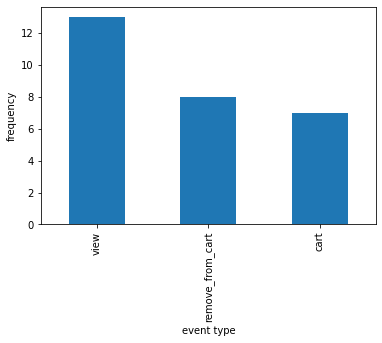

In [18]:
data['event_type'].value_counts().plot(kind='bar', xlabel='event type', ylabel='frequency')
plt.show()

**סעיף 6**

In [19]:
#CREATE A NEW DATAFRAME
session_data = data.loc[:, ['user_id', 'user_session', 'funnel_number','index_in_funnel']].drop_duplicates()


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['funnel_number', 'index_in_funnel'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [20]:
#COUNT num of event for session
datacounts = data.groupby('user_session')['event_time'].count()
session_data ['num_of_event'] = session_data ['user_session'].map(datacounts)

NameError: name 'session_data' is not defined

In [21]:
#TIME of event for session
datatime = data.groupby('user_session')['event_time'].apply(lambda x: x.max() - x.min())
session_data ['connection_time'] = session_data ['user_session'].map(datatime)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [22]:
#PRODUCT ID view for session
view_products_list = data[data['event_type'] == 'view'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_viewed'] = session_data ['user_session'].map(view_products_list)

NameError: name 'session_data' is not defined

In [23]:
#PRODUCT ID cart for session
cart_products_list = data[data['event_type'] == 'cart'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_added_to_cart'] = session_data ['user_session'].map(cart_products_list)

NameError: name 'session_data' is not defined

In [24]:
#PRODUCT ID purchase for session
purchases_products_list = data[data['event_type'] == 'purchase'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_purchased'] = session_data ['user_session'].map(purchases_products_list)

NameError: name 'session_data' is not defined

In [25]:
session_data

NameError: name 'session_data' is not defined